In [1]:
import torch
import pandas as pd
from skimage import io, transform, color
from PIL import Image

from torchvision import models
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import dataset, dataloader, Dataset
from torchvision import transforms, utils

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import pandas as pd
from glob import glob
np.random.seed(42)
all_dirs = glob("data/tiny-imagenet-200/train/*")
dirs = np.random.choice(all_dirs, 20)
data = []
for img_dir in dirs:
    imgs_in_dir = glob(img_dir + "/images/*.JPEG")
    name = img_dir.split("/")[-1]
    for img in imgs_in_dir:
        data.append([name, img])
        
train_df = pd.DataFrame(data, columns=["name", "image"])



In [5]:
train_df.head()


,name,image
0,n04070727,data/tiny-imagenet-200/train/n04070727/images/...
1,n04070727,data/tiny-imagenet-200/train/n04070727/images/...
2,n04070727,data/tiny-imagenet-200/train/n04070727/images/...
3,n04070727,data/tiny-imagenet-200/train/n04070727/images/...
4,n04070727,data/tiny-imagenet-200/train/n04070727/images/...


In [6]:
class ImageDataset(Dataset):

    def __init__(self, df, transform=None, alexnet_feature=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        # self.root_dir = root_dir
        self.transform = transform
        self.alexnet_feature = alexnet_feature

    def __len__(self):
        return self.df.shape[0] 

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = io.imread(self.df.iloc[idx].image)
        # image = read_image(self.df.iloc[idx].image).float()
        # image = Image.open(self.df.iloc[idx].image)
        if len(image.shape) == 2:
            image = color.gray2rgb(image)
        # adds another dimension to the image channel
        name = f"{self.df.iloc[idx].name}"
        sample = {'name': name, 'image': image}
        # print("name", sample['name'], sample['image'].shape)
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        if self.alexnet_feature:
            sample['alex'] = self.alexnet_feature(sample['image'])

        return sample

In [8]:
import torchvision.transforms.functional as fn

In [9]:

transformed_dataset = ImageDataset(train_df,
                                   transform=transforms.Compose([
                                       Rescale((227, 227)),
                                       # transforms.Resize(227),
                                       # RandomCrop(224),
                                       ToTensor(),
                                       # transforms.ToTensor(),
                                    #    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                   ]),
                                    alexnet_feature=GetAlexConv(layer_number=[0,12], layer_name='maxpool5'),
                                   )


In [10]:
img = transformed_dataset[100]["image"]
print(img.size())
transformed_dataset[100]['alex'].size()

torch.Size([3, 227, 227])


torch.Size([256, 6, 6])

In [166]:
pil  = transforms.ToPILImage()(transformed_dataset[100]['image'])
plt.imshow(pil)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [12]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [37]:
# print(net)


In [195]:
import torch.optim as optim

trainloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=64,
                                          shuffle=True, num_workers=0)


criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)


In [196]:
len(trainloader)

157

In [187]:

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # name, image, fix_map = data
        image = data['image'].to(device)
        input_image = data['alex'].to(device)
        optimizer.zero_grad()
        print(".", end="")
        # forward + backward + optimize
        outputs = net(input_image)
        image_resize = fn.resize(image, size=192)
        loss = criterion(outputs, image_resize)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        # if i % 50 == 49:    # print every 2000 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 50))
        #     running_loss = 0.0

    print("epoch", epoch, running_loss / len(trainloader))

print('Finished Training')


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [182]:
running_loss

1.3437084555625916

In [13]:
net(image).size()

NameError: name 'net' is not defined

In [ ]:
# https://medium.com/the-owl/extracting-features-from-an-intermediate-layer-of-a-pretrained-model-in-pytorch-easy-way-62631c7fa8f6
# maybe some help from this article
# this one visualize the output of the convolutional layer
# https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573
# how to get the hook
# https://medium.com/dataseries/visualizing-the-feature-maps-and-filters-by-convolutional-neural-networks-e1462340518e

In [14]:
ex = transformed_dataset[0]['image']
print(ex.size())
batch = ex.unsqueeze(0)
print(batch.size())

torch.Size([3, 227, 227])
torch.Size([1, 3, 227, 227])


In [15]:

alex = models.alexnet(pretrained=True)

for param in alex.parameters():
    param.requires_grad = False

In [16]:
ans = alex(batch)

In [17]:
child = list(alex.children())

print(child)

[Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
), AdaptiveAvgPool2d(output_size=(6, 6)), Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_fe

In [18]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [51]:
# child[0][3].weight.size() # conv 2


layer = 'conv2'
alex = models.alexnet(pretrained=True)
for param in alex.parameters():
    param.requires_grad = False
child = list(alex.children())
conv_five = child[2][2]
conv_five.register_forward_hook(get_activation(layer))


In [52]:
child

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
   (1): ReLU(inplace=True)
   (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (4): ReLU(inplace=True)
   (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (7): ReLU(inplace=True)
   (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (9): ReLU(inplace=True)
   (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
 ),
 AdaptiveAvgPool2d(output_size=(6, 6)),
 Sequential(
   (0): Dropout(p=0.5, inplace=False)
   (1): Linear(in_features=9216, out_features=4096, bias=True)
   (2): ReLU(inplace=True)
   (3): Dropout(p=0.5, inplace=False)

In [53]:
conv_five

ReLU(inplace=True)

In [54]:

ans = alex(batch)
a = activation[layer]
print(a.size())

torch.Size([1, 4096])


In [55]:
batch.size()

torch.Size([1, 3, 227, 227])

In [216]:

# conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
# conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
# upconv1 = nn.ConvTranspose2d(256, 256, kernel_size=5, stride=2, padding=2)
# upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=1)
# upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=1)
# upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=1)
# upconv5 = nn.ConvTranspose2d(32, 3, kernel_size=5, stride=2, padding=1, output_padding=1)
#

conv2 = nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1)
conv3 = nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1)
upconv1 = nn.ConvTranspose2d(192, 192, kernel_size=5, stride=2, padding=1)
upconv2 = nn.ConvTranspose2d(192, 96, kernel_size=5, stride=2, padding=1)
upconv3 = nn.ConvTranspose2d(96, 48, kernel_size=5, stride=2, padding=1)
upconv4 = nn.ConvTranspose2d(48, 24, kernel_size=5, stride=2, padding=1)
upconv5 = nn.ConvTranspose2d(24, 3, kernel_size=5, stride=1, padding=0)

out2 = conv2(a)
print('out2', out2.size())
out3 = conv3(out2)
print('out3', out3.size())
upout1 = upconv1(out3)
print('upout1', upout1.size())
upout2 = upconv2(upout1)
print('upout2', upout2.size())
upout3 = upconv3(upout2)
print('upout3', upout3.size())
upout4 = upconv4(upout3)
print('upout4', upout4.size())
upout5 = upconv5(upout4)
print('upout5', upout5.size())


out2 torch.Size([1, 192, 13, 13])
out3 torch.Size([1, 192, 13, 13])
upout1 torch.Size([1, 192, 27, 27])
upout2 torch.Size([1, 96, 55, 55])
upout3 torch.Size([1, 48, 111, 111])
upout4 torch.Size([1, 24, 223, 223])
upout5 torch.Size([1, 3, 227, 227])


In [1]:

upout5.size()

NameError: name 'upout5' is not defined

In [56]:
fc1 = nn.Linear(4096, 4096)
fc2 = nn.Linear(4096, 4096)
fc3 = nn.Linear(4096, 4096)
up1 = nn.ConvTranspose2d(256, 256, kernel_size=5, stride=2, padding=2, output_padding=1)
up2 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1)
up3 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1)
up4 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
up5 = nn.ConvTranspose2d(32, 3, kernel_size=5, stride=2, padding=2, output_padding=1)

print("a", a.size())
outf1 = fc1(a)
print("outf1", outf1.size())
outf2 = fc2(outf1)
print("outf2", outf2.size())
outf3 = fc3(outf2)
print("outf3", outf3.size())
res = outf3.view(outf3.size(0), 256, 4, 4)
print("res", res.size())
upout1 = up1(res)
print("upout1", upout1.size())
upout2 = up2(upout1)
print("upout2", upout2.size())
upout3 = up3(upout2)
print("upout3", upout3.size())
upout4 = up4(upout3)
print("upout4", upout4.size())
upout5 = up5(upout4)
print("upout5", upout5.size())



a torch.Size([1, 4096])
outf1 torch.Size([1, 4096])
outf2 torch.Size([1, 4096])
outf3 torch.Size([1, 4096])
res torch.Size([1, 256, 4, 4])
upout1 torch.Size([1, 256, 8, 8])
upout2 torch.Size([1, 128, 16, 16])
upout3 torch.Size([1, 64, 32, 32])
upout4 torch.Size([1, 32, 64, 64])
upout5 torch.Size([1, 3, 128, 128])


In [24]:
print(upout5.size())


torch.Size([1, 3, 301, 301])


In [26]:
afive = activation['conv5']
afive.squeeze(0)
gray_scale = torch.sum(afive,0)
gray_scale = gray_scale / afive.shape[0]

In [27]:
gray_scale.shape

torch.Size([256, 15, 15])

In [31]:
child = list(alex.children())

print(child)

[Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
), AdaptiveAvgPool2d(output_size=(6, 6)), Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_fe

In [33]:
child[0][3].weight.size() # conv 2


# child[0][10].weight.size()


Parameter containing:
tensor([[[[ 3.6245e-03,  1.4335e-03,  3.7217e-02, -2.0926e-02,  1.8121e-03],
          [ 2.4126e-02, -1.2056e-02,  7.1170e-02, -8.5224e-02,  1.3067e-02],
          [ 2.0966e-02, -1.0623e-01,  2.1572e-02, -6.9547e-02,  3.1583e-02],
          [-8.3392e-03, -3.9020e-02, -4.6621e-02,  2.2133e-02, -1.3252e-03],
          [-1.5370e-02,  8.6569e-03,  3.1479e-02,  1.6698e-02, -4.7130e-03]],

         [[-5.4573e-03, -1.9087e-02, -3.2424e-02, -2.2006e-02, -1.2120e-02],
          [-7.4972e-03,  3.0946e-02,  3.1899e-02, -7.6327e-03, -1.4720e-02],
          [ 5.4830e-03,  8.0306e-02,  6.1262e-02,  1.3252e-02,  2.6240e-02],
          [-2.6938e-02,  5.9188e-03,  3.8373e-02, -6.3116e-03,  3.9863e-03],
          [ 2.0844e-03, -3.6292e-02, -2.1987e-03, -1.6570e-02,  5.6354e-03]],

         [[-1.2587e-02, -5.9436e-02, -9.6281e-02,  1.6745e-02,  4.7471e-02],
          [-1.5036e-02, -1.1214e-01, -2.3924e-02,  3.3459e-02,  4.1306e-02],
          [-1.3845e-02,  4.1235e-02,  2.1580e-01, 

In [18]:
# freeze alex net paramsiiiiuuuooo

In [19]:
alex.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


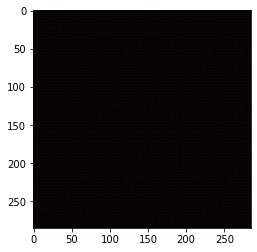

In [56]:

sam = upout5[0,:,:,:]
plt.imshow(sam.permute(1, 2, 0).detach().numpy())